# Imports

In [1]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm 
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import scipy
import random
from skimage.feature import greycomatrix, greycoprops
from glrlm import GLRLM
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.filterwarnings("ignore")

# Reading the data

The first step in solving the problem is to read the files from each directory and pair the flair images with its mask. 

In [2]:
path = r'Data\Train'

In [365]:
def reader(path,title,fix=0):
    
    def interpreter(file_name):
        if 'mask' not in file_name:
            patient = file_name[:3]
            flair = file_name[file_name.find('R')+1:file_name.find('.')]
        else:
            patient = file_name[:3]
            flair = file_name[file_name.find('R')+1:file_name.find('_',5)]
        return int(patient),int(flair)
    
    files = os.listdir(path)
    I,M = [],[]
    for l in files:
        if 'mask' not in l:
            I.append(l)
        else:
            M.append(l)
    
    final = []
    for i in I:
        for m in M:
            if interpreter(i) == interpreter(m):
                final.append((i,m))
    
    print(f'Number of {title} images: {len(final)}')
    
    images = []
    for k in range(len(final)):
        patient = final[k][0][:3]
        flair = final[k][0][9:11]
        fi = np.array(Image.open(path+r'\\'+final[k][0]))
        fm = np.array(Image.open(path+r'\\'+final[k][1])) - fix
        images.append((patient,flair,(fi,fm)))
    
    F = {}
    for i in images:
        if i[0] not in F.keys():
            fm = np.array(Image.open(path+'\\'+final[k][1])) - fix
            F[i[0]] = {'type':title,i[1]:i[2]}
        else:  
            F[i[0]][i[1]] = i[2] 
    
    return F

In [382]:
F_avc = reader(path+r'\AVC','AVC',fix=253)
F_em = reader(path+r'\EM','EM',fix=253)

Number of AVC images: 581
Number of EM images: 630


In [383]:
F = {}
F.update(F_avc)
F.update(F_em)

Next we create a dictionary with each patient number as keys and another dictionary as values containing the lesion type and the pair of arrays (flair,mask) of the same patient. this data structure will be the input of most defined functions here.

# Functions

We define a function _splitter_ that takes the complete collection of patients _F_ and splits them randomly into a subset _F\_train_ with 40 of 50 AVC patients and 40 of 51 EM patients, and a second subset _F\_test_ with the remaining 10 AVC and 11 EM patients.

In [5]:
def splitter(F):
    a,e = [],[]
    for i in F.keys():
        if F[i]['type'] == 'AVC':
            a.append(i)
        elif F[i]['type'] == 'EM':
            e.append(i)
    avc = random.sample(a,40)
    em = random.sample(e,40)
    F_train = {i:F[i] for i in (avc + em)}
    F_test = {j:F[j] for j in set(a+e)-set(F_train.keys())}
    return F_train,F_test

The function _normalizer_ takes an image array and a normalizing method and returns the normalized version of the image.
Here we test 5 approaches:
- No normalizing method
- Min-max normalization
- Decimal scaling normalization
- Z-score normalization
- Robust scaling normalization
- Tanh normalization

In [6]:
def normalizer(image_array,method):
    """Normalizes the image
       minmax, ds, zs, rs, tanh"""
    if not method:
        return image_array
    if method == 'minmax':
        scaler = MinMaxScaler([0,1])
        scaler.fit(image_array)   
        return scaler.transform(image_array)
    elif method == 'ds':
        return image_array/10**np.size(np.max(image_array))
    elif method == 'zs':
        return (image_array - np.mean(image_array))/np.std(image_array)
    elif method == 'rs':
        return (image_array - np.median(image_array))/(scipy.stats.iqr(image_array))
    elif method == 'tanh':
        est = sm.robust.norms.Hampel().weights(image_array)
        return 0.5*(np.tanh(0.01*(image_array-np.mean(est))/np.std(est))+1)
    else:
        return None

The function _attributes_ receives an image array and its mask, as well as the normalizing method, and returns a list with the chosen attributes to serve as features for the SVM.

In [7]:
def attributes(image,mask,*args,method=None):
    """Returns the attributes from an image"""
    A = []
    norm_image = normalizer(image,method)*mask
    pure_image = image*mask
    level = np.max(image)
    glcm = greycomatrix(pure_image, distances=[5], angles=[90], levels=level+1, symmetric=True, normed=True)
    
    if 'contrast' in args:
        A.append(greycoprops(glcm, prop='contrast')[0][0])
    if 'dissimilarity' in args:
        A.append(greycoprops(glcm, prop='dissimilarity')[0][0])
    if 'homogeinity' in args:
        A.append(greycoprops(glcm, prop='homogeneity')[0][0])
    if 'asm' in args:
        A.append(greycoprops(glcm, prop='ASM')[0][0])
    if 'energy' in args:
        A.append(greycoprops(glcm, prop='energy')[0][0])
    if 'correlation' in args:
        A.append(greycoprops(glcm, prop='correlation')[0][0])
    
    bins = 150
    h,_ = np.histogram(norm_image,bins,(1,255))
    if 'mean' in args:
        A.append(np.mean(h))
    if 'std' in args:
        A.append(np.std(h))
    if 'skewness' in args:
        A.append(scipy.stats.skew(h))
    if 'kurtosis' in args:
        A.append(scipy.stats.kurtosis(h))
    if 'entropy' in args:
        A.append(scipy.stats.entropy(h))
    if 'max' in args:
        A.append(np.max(h))
    return tuple(A)

The _data\_preparing_ function will receive the data _F_ and the normalizing method and extract the attributes for each image and the correct label, returning the X (features) and Y (labels) to be used in the SVM.

In [8]:
def data_preparing(F,*args,method=None):
    L = []
    Y = []
    c = 0
    M = []
    for patient in F.keys():
        for flair in F[patient].keys():
            if flair.isdigit():
                L.append(attributes(F[patient][flair][0],F[patient][flair][1],*args,method))
                Y.append(F[patient]['type'])
                M.append(patient)
    return L,Y,M

The _N_ function is made to normalize the attributes to improve the learning of the SVM. The normalization used is the Z-score.

In [9]:
def N(L):
    """Normalizes the attributes"""
    D = pd.DataFrame(L)
    for column in range(len(D.columns)):
        D[column] = (D[column] - np.mean(D[column]))/np.std(D[column])
    return D.dropna(axis=1)

# Prediction

We received a second folder with 225 patients without labels and we will attempt to train a svm model and predict those labels in the following code.

In [378]:
path2 = r'Data\Test'

#### 1. Reading the files

In [15]:
files_test = os.listdir(path2)


def interpreter(file_name):
    if 'mask' not in file_name:
        patient = file_name[:3]
        flair = file_name[file_name.find('R')+1:file_name.find('.')]
    else:
        patient = file_name[:3]
        flair = file_name[file_name.find('R')+1:file_name.find('_',5)]
    return int(patient),int(flair)

I_test = []
M_test = []
for l in files_test:
    if 'mask' not in l:
        I_test.append(l)
    else:
        M_test.append(l)


# Pairing an image and its mask
final_test = []
for i in I_test:
    for m in M_test:
        if interpreter(i) == interpreter(m):
            final_test.append((i,m))

print(f'Number of test images: {len(final_test)}')

Number of test images: 225


In [379]:
reader(path2,'Unknown',fix=253)

Number of Unknown images: 225


{'150': {'type': 'Unknown',
  '16': (array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]))},
 '151': {'type': 'Unknown',
  '25': (array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]

#### 2. Creating the data dictionary 

In [29]:
with open(r'Correct.txt','r') as f:
    a = f.read().split('\n')
    correct = {a[i].split()[0]: a[i].split()[1] for i in range(len(a)) if a[i]}
correct

images_test = []
for k in range(len(final_test)):
    patient = final_test[k][0][:3]
    flair = final_test[k][0][9:11]
    fi = np.array(Image.open(path2+'\\'+final_test[k][0]))
    fm = np.array(Image.open(path2+'\\'+final_test[k][1])) - 253
    images_test.append((patient,flair,(fi,fm)))

F2 = {}
for i in images_test:
    if i[0] not in F2.keys():
        fm = np.array(Image.open(path2+'\\'+final_test[k][1])) - 253
        F2[i[0]] = {'type':correct[i[0]],i[1]:i[2]}
    else:  
        F2[i[0]][i[1]] = i[2] 

print(F2)

{'150': {'type': 'AVC', '16': (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))}, '151': {'type': 'EM', '25': (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))}, '152': {'type': 'AVC', '14': (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0,

#### 3. Training the model

In [515]:
method = None

F_train,F_test = splitter(F)
x_train,y_train,_ = data_preparing(F_train,'kurtosis',method)
x_test,y_test,_ = data_preparing(F_test,'kurtosis',method)
x_train,x_test = N(x_train),N(x_test) 


y_train = np.ravel(y_train)
clf = svm.SVC(C=10000, gamma=0.01, kernel="rbf")
clf.fit(x_train, y_train)
predicted = clf.predict(x_test)
y_pred=clf.predict(x_test)

accuracy_score(y_pred,y_test)*100

91.2

#### 5. Making the prediction

In [516]:
#Accuracy of the prediction (1)
x2,y2,m = data_preparing(F2,'kurtosis',method)
x2 = N(x2) 
y_pred2=clf.predict(x2)
accuracy_score(y_pred2,y2)*100

94.22222222222221

In [519]:
T = tuple(zip(m,y_pred2))
prediction = {i[0][0]:i[1] for i in T}
prediction

{'150': 'AVC',
 '151': 'EM',
 '152': 'AVC',
 '153': 'EM',
 '154': 'EM',
 '155': 'AVC',
 '156': 'EM',
 '157': 'EM',
 '158': 'EM',
 '159': 'AVC',
 '160': 'EM',
 '162': 'AVC',
 '163': 'AVC',
 '166': 'EM',
 '167': 'EM',
 '169': 'EM',
 '170': 'AVC',
 '171': 'EM',
 '172': 'AVC',
 '173': 'EM',
 '174': 'EM',
 '175': 'EM',
 '176': 'AVC',
 '177': 'AVC',
 '178': 'EM',
 '179': 'AVC',
 '180': 'AVC',
 '181': 'EM',
 '182': 'EM',
 '183': 'AVC',
 '184': 'EM',
 '185': 'EM',
 '186': 'EM',
 '187': 'EM',
 '188': 'EM',
 '191': 'EM',
 '192': 'EM',
 '193': 'EM',
 '194': 'EM',
 '195': 'EM',
 '196': 'EM',
 '197': 'AVC',
 '198': 'AVC',
 '199': 'EM',
 '200': 'AVC',
 '201': 'EM',
 '203': 'AVC',
 '204': 'EM',
 '205': 'AVC',
 '206': 'EM',
 '207': 'AVC',
 '208': 'EM',
 '209': 'AVC',
 '210': 'EM',
 '211': 'AVC',
 '212': 'EM',
 '213': 'EM',
 '214': 'EM',
 '215': 'EM',
 '216': 'EM',
 '217': 'EM',
 '218': 'EM',
 '219': 'AVC',
 '220': 'EM',
 '221': 'AVC',
 '222': 'EM',
 '223': 'AVC',
 '224': 'AVC',
 '225': 'EM',
 '226': '

In [520]:
#Accuracy of the prediction (2)
s = 0
for i in prediction.keys():
    if prediction[i] == correct[i]:
        s += 1
100*s/225

94.22222222222223

#### 6. Creating the file

In [481]:
T = tuple(zip(m,y_pred2))
with open(r'C:\Users\Luan\Luan Dropbox\Luan Silveira\PC\Desktop\ra204099.txt','w') as f:
    f.write('\n'.join([t[0]+' '+t[1] for t in T]))

# Lupus

###### 1. Introduction

Brain lesions are a type of damage to the brain that may be caused, among other things, by three main conditions:
1. Stroke - A vascular injury or cut of blood supply to the brain. It's perhaps the main cause of brain injuries.
2. Multiple Sclerosis - A condition where lesions appear in multiple areas of the brain.
3. Lupus - An autoimmune disease with multiple manifestations and that can cause brain lesions.

A common way of diagnosing these types of lesions is through imaging of the brain, such as computed tomography (CT) and magnetic resonance imaging (MRI). These images are then examined by a doctor who will classify the type of lesion. With this approach in mind, our first proposal is to train a machine learning model to learn how distinguish between brain lesions caused by stroke and multiple sclerosis, evaluate the performance and relevant attributes being used in the decision making with the hope of a better medical insight into these brain lesions. The second step consists in using the trained model to classify lupus lesions into either a stroke or multiple sclerosis, with the objective of finding similarities that these types of lesions may share.


###### 2. Metodology

We were given an initial folder with medical images of brain lesions caused by two conditions, stroke (AVC) and multiple sclerosis (EM). Our first goal consists in using this dataset to training a svm model to classify a brain lesion into these two classes. We begin by taking the complete collection of patients and randomly splitting them in a 80-20 proportion for the training and test sets (the split was made by patient and not by image to avoid the same patient being used in both the training and test sets). With both sets defined we need to decide on a image normalization approach, for this we trained 100 models with each method and display the statistics of the accuracy in the table below.


Method|Min|Max|Mean|Std
-|-|-|-|-
Normal|60.869565|97.991968|90.281728|6.087545
MinMax|64.5283082|98.734177|89.771374|5.069562
DS|44.758065|96.511628|83.148129|13.452082
ZS|45.588235|94.809689|79.300250|13.104043
Tanh|48.571429|94.901961|81.477037|11.744619

As we can see the no normalization method had a better result since the mean accuracy is the best with 90.28% and it doesn't drop below 60% precision with a relatively low standard deviation. We decided to move foward with the no normalization.

Our next step is to compare each feature to determine the best attributes to the model. We do this also running 100 models with a single different attribute and measuring the minimum, maximum, standard deviation and mean accuracy scores.

Attribute|Mean|Min|Max|Std
-|-|-|-|-
Kurtosis|91.31|80.00|99.62|4.26
Skewness|91.06|77.21|99.64|4.80
Entropy|86.63|76.89|96.51|4.14
Max|85.49|41.98|96.08|6.07
Mean|85.27|35.22|95.30|6.78
Std|85.00|37.86|95.88|8.18
Correlation|83.90|76.81|90.53|2.94
Contrast|79.61|67.98|88.69|4.80
Dissimilarity|76.89|66.09|86.76|4.40
ASM|75.15|51.97|85.42|4.80
Energy|74.77|61.90|86.36|3.99
Homogeinity|72.31|58.97|82.03|4.05

The kurtosis showed the best performance with a 91.31% mean accuracy score and never dropping below 80%. After also trying a combination of the top performers we arrive at the following result.

Combination|Mean|Min|Max|Std
-|-|-|-|-
Skewness,Kurtosis,Entropy,Max,Mean,Std|91.15|80.21|99.66|4.46
Skewness,Kurtosis,Entropy|90.84|74.62|98.98|4.67
Skewness,Kurtosis|90.50|77.99|99.59|4.54

As the table above shows there was no real gain from when we used a single attribute. Thus, we will then attempt to train the final svm model only with the kurtosis for simplicity and performance.

The kurtosis of a distribution is commonly interpreted as being related to the shape of the curve. Matematically, its given by the equation $k = \mu_4/\sigma^4$, where $\mu_4$ is the fourth moment of the distribution and $\sigma$ is the standard deviation. Distributions with a negative excess kurtosis, that is, kurtosis minus 3, are called platykurtic and tends to have a tinner tail, meaning that it produces fewer extreme outliers. On the other hand, distributions with a positive kurtosis are known as leptokurtic and have a "fatter tail", producing more extreme outliers. The normal distribution is called meso

The dataset was again ramdonly split into a 80-20 proportion of patients for training and test, the kurtosis was extracted from the image of the lesion (that is, we applyied the mask into the image to obtain only the lesion, and also throwed out the zero pixels with the idea that the model should only be exposed to information of the lesions themselves to be able to distinguish them) and normalized before being given to the classifier.

The final svm had a accuracy score of 91.2% on the testing set, and will be used to classify lesion types from lupus into stroke or multiple sclerosis.


###### 3. Results

The first thing to notice is that each given patient has multiple images, and the svm will attempt to classify each image separately, so it's possible that the model will diagnose the same patient with different lesion types depending on the given flair. This is not a problem since our focus here is to study the criteria that it uses to decide on a diagnosis, and looking at different flairs with different diagnosis of the same patient might give us an insight into what the model considers relevant in classifying.

The model used was training with the original 581 images from the 50 stroke patients and the 630 images from the 51 multiple sclerosis ones. No image normalization method was used since it proved inefficient in our previous study. However, the attributes were normalized using the z-score method so its values are closer distributed.

In [540]:
path3 = r'Data\SLE'
F_lu = reader(path3,'Lupus')

Number of Lupus images: 697


In [417]:
def data_preparing(F,*args,method=None):
    L = []
    Y = []
    c = 0
    M = []
    for patient in F.keys():
        for flair in F[patient].keys():
            if flair.isdigit():
                L.append(attributes(F[patient][flair][0],F[patient][flair][1],*args,method))
                Y.append(F[patient]['type'])
                M.append((patient,flair))
    return L,Y,M

In [541]:
# Making the prediction
method=None
x3,y3,m3 = data_preparing(F_lu,'kurtosis',method)
x3 = N(x3) 
y_pred3=clf.predict(x3)

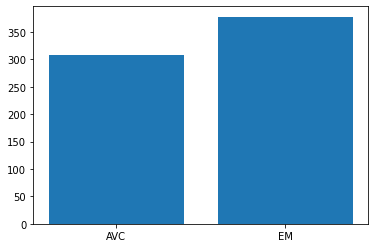

In [546]:
# Prediction results
B = np.unique(y_pred3,return_counts=True)
plt.bar(*B)
plt.show()

As we can see from the histogram above the model classified around 55% of the images as multiple sclerosis and 45% as stroke. Lets display the flairs for 5 different patients and the corresponding svm classification label and kurtosis value.

Patient: 601
Lesion: Lupus


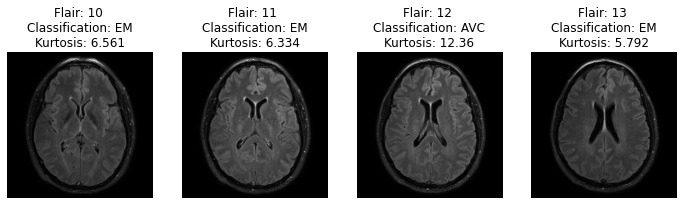

----------------------------------------------------------------------------------------------------
Patient: 604
Lesion: Lupus


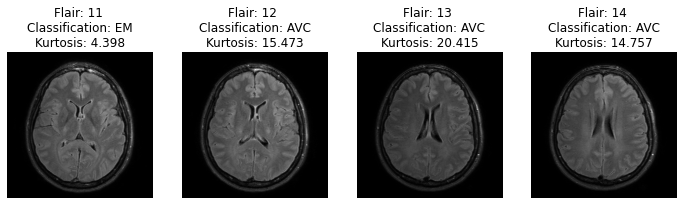

----------------------------------------------------------------------------------------------------
Patient: 616
Lesion: Lupus


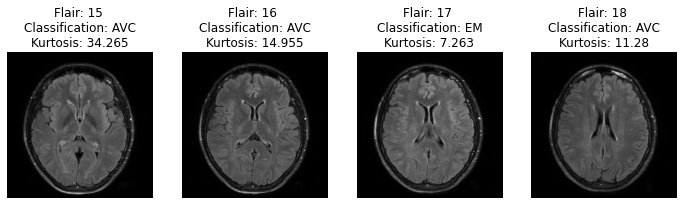

----------------------------------------------------------------------------------------------------
Patient: 621
Lesion: Lupus


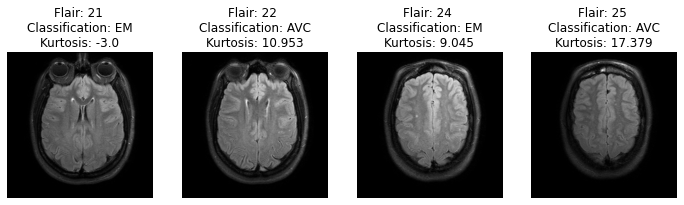

In [524]:
P = {(i[0],i[1]):j for i,j in tuple(zip(m3,y_pred3))}

def show(patient):
    n = len(F_lu[patient].keys())-1
    fig,axis = plt.subplots(1,n,figsize=(12,8))
    c = 0
    temp = {patient:F_lu[patient]}
    for flair in F_lu[patient].keys():
        if flair.isdigit():
            axis[c].imshow(F3[patient][flair][0],cmap='gray')
            axis[c].set_title(f'Flair: {int(flair)} \nClassification: {P[(patient,flair)]}\nKurtosis: {round(data_preparing(temp,"kurtosis")[0][c][0],3)}')
            axis[c].axis(False)
            c+=1
    print(f'Patient: {patient}\nLesion: Lupus')
    plt.show()
    
show('601')
print(100*'-')
show('604')
print(100*'-')
show('616')
print(100*'-')
show('621')

The images suggest that a frontier exists around a kurtosis value of 10, where an image with a value higher than 10 gets classified as a stroke lesion and a lower value as multiple sclerosis. To confirm our hipotesis lets plot the distribution of kurtosis values for each lesion type.

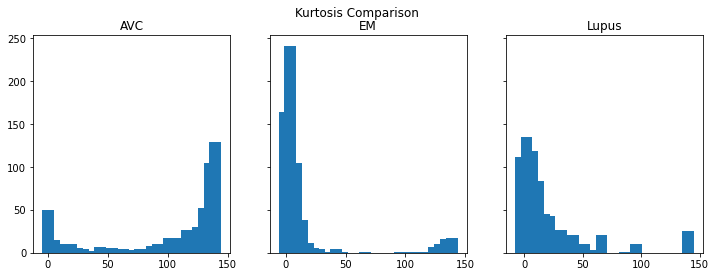

In [565]:
variable = 'kurtosis'
width = 10
nbins=30
method=None

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4),sharey=True) 
fig.suptitle(variable.capitalize()+' Comparison')


l_avc,y_avc,m_avc = data_preparing(F_avc,variable,method=method)
h_avc, bin_edges_avc = np.histogram(l_avc,bins=nbins)
bin_centers_avc = bin_edges_avc[1:]-(width/2)
ax1.bar(bin_centers_avc,h_avc,width=width)
ax1.set_title('AVC')

l_em,y_em,m_em = data_preparing(F_em,variable,method=method)
h_em, bin_edges_em = np.histogram(l_em,bins=nbins)
bin_centers_em = bin_edges_em[1:]-(width/2)
ax2.bar(bin_centers_em,h_em,width=width)
ax2.set_title('EM')

l_lu,y_lu,m_lu = data_preparing(F_lu,variable,method=method)
h_lu, bin_edges_lu = np.histogram(l_lu,bins=nbins)
bin_centers_lu = bin_edges_lu[1:]-(width/2)
ax3.bar(bin_centers_lu,h_lu,width=width)
ax3.set_title('Lupus')

fig.show()

As we suspected the kurtosis values for multiple sclerosis (EM) images are more heavily distributed closer to 0 and the kurtosis for stroke (AVC) tends to have a higher value. When attempting to classify the lupus images we can assume that the svm has learned to diagnose as stroke (AVC) images with a kurtosis higher than a certain threshold and as multiple sclerosis below this value.

###### 4. Conclusion

Evaluating the performance of the svm classifier using only the kurtosis as attribute, we got on average above 90% accuracy, suggesting that this attribute was a good choice for this problem. Observing the meaning of kurtosis in a distribution we can infer that on stroke (AVC) images the pixels are more narrowly located in a specific range, with a fewer pixels outside these values. In contrast, the relative low values for the kurtosis on multiple sclerosis (EM) suggests that these kind of lesion images have a wider range of pixel values. We can go further and hypothesise that brain lesions caused by a stroke creates a more homogeneous scar tissue while multiple sclerosis is more likely to cause a more heterogeneous lesion.

It is also important to note the possibility of this result being a reflection of a possible bias from the dataset, where one class of lesion naturally darker or lighter than the other.